# Formulating optimization problems using built-in `ws3.forest.ForestModel` class methods  

The `ws3.forest.ForestMdoel` class includes a number of methods to automate formulation and solution of optimization problems. In this notebook, we will demonstrate how to use these methods to formulate various common forms of objective functions and constraints, how to combine these in various ways, and how to solve these problems using the built-in solvers.

Below we (optionally) install the `ws3` package from the local source code in this repository using the `-e` flag to ensure that the package is installed in editable mode (i.e., any changes you make to the source code immediately affect `ws3` behaviour the next time you run the notebook). This is is not necessary if you have installed `ws3` using pip or another method.

Note that the code in this notebook has been tested with the version of the `ws3` package that is included in this repository. 

In [1]:
# this is a markdown cell, not a code cell.
clobber_ws3 = True
if clobber_ws3:
    %pip uninstall -y ws3
    %pip install -e ..

Found existing installation: ws3 0.0.1.post3
Uninstalling ws3-0.0.1.post3:
  Successfully uninstalled ws3-0.0.1.post3
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///home/gep/projects/ws3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ws3 (pyproject.toml) ... done
  Created wheel for ws3: filename=ws3-0.0.1.post3-py2.py3-none-any.whl size=1858 sha256=188b238258444a4e75f5e66493ff88df2e24f62f61172d5ab8024a83d25e0aa0
  Stored in directory: /tmp/pip-ephem-wheel-cache-duflyuq2/wheels/8a/d1/f0/2b533a60b366fa03a12ca91a1ad068761e66b9df68fa0cadb9
Successfully built ws3
Note: you may need to restart the kernel to use updated packages.


Set auto-reload to reload modules when they are changed.

In [2]:
%load_ext autoreload
%autoreload 2

Import required packages.

In [3]:
import matplotlib.pyplot as plt
import ws3
import ws3.forest
import functools
import pandas as pd

Set some reasonable model parameters.

In [4]:
base_year = 2020    # base year for the problem
horizon = 10        # number of periods in the simulation horizon
period_length = 10  # period length (in years)
max_age = 1000      # maximum age of a stand (in years)
tvy_name = 'totvol' # name for total volume yield component

Create a new `ForestModel` object and import a model dataset from the `data` directory.

In [5]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.actions['harvest'].is_harvest = True # set harvest action to be a harvest action (needed for `cmp_c_z` to work correctly)

# Maximizing harvest volume

We will start by defining a basic optimization problem, where we simply maximize the sum of harvest volume across all time periods. 

The optimization functions in `ws3` are very flexible, but this flexibility comes at a cost: the user has to define various functions that generate the linear programming (LP) optimization problem matrix coefficients.

We will start by defining a function `cmp_c_z` (you can use any name you want for coefficient functions) that returns the objective function coefficient for a single column in the matrix. Note that `ws3` is using a Model I formulation of the LP problem, where each column of the matrix represents a unique feasible combination of actions across all time periods (for a given combination of development type and initial age class). Internally `ws3` handles iterating through each development type/age class combination, and generating dynamic programming state trees, where each unique _path_ from the root node of a tree through to a leaf node is represented by a unique column in the matrix. Each path has one node per time period in the simulation horizon.

The `cmp_c_z` function will be used by `ws3` to generate the coefficients for each column in the matrix. The `cmp_c_z` function takes three arguments: the first argument is a `ForestModel instance`, the second argument is a `path` (a list of node objects), and the third argument is an `expr` (a string expression that evaluates to a number, which we pass to the `ForestModel.compile_product` method).

See the [ws3 documentation](https://ws3.readthedocs.org) for more information about what types of expressions `ws3` can resolve in this context. For our example we will use a simple expression that multiplies total merchantable volume in the `totvol` yield component by 0.85 to simulate an 85% fibre utilization rate (i.e., 15% of total merchnantable volume is left behind as harvest residues in slash piles or spread across cut blocks).


The Model I LP optimization problem can be formulated as follows:

$$
\begin{align}
  \text{max} \quad &  \sum_{i\in I}\sum_{j \in J_{i}}c_{ij}x_{ij} & \\
  \text{s.t.} \quad & \nonumber \\
   &(1-\varepsilon_{p})y_p \leq \sum_{i\in I}\sum_{j\in J_{i}}\mu_{ijpt}x_{ij}  \leq  (1+\varepsilon_{p})y_p, & \forall p\in O', t\in T'_p \\
   &v^{-}_{ot}\leq\sum_{i\in Z}\sum_{j\in J_{i}}\mu_{ijot}x_{ij}  \leq v^{+}_{ot}, &  \forall o\in O, t\in T \\
   &\sum_{j\in J_{i}}x_{ij}  = 1, \forall i\in Z \\
   &0 \leq x_{ij} \leq 1, & \forall i \in Z, j \in J_{i} 
\end{align}
% \end{eqnarray}
$$

where

$$
\begin{align*}
  I := & \,\, \text{set of spatial zones}\\
  J_{i} := & \,\, \text{set of available prescriptions for zone $i \in I$}\\
  O := & \,\, \text{set of forest outputs}\\
  O' \subseteq O := & \,\, \text{set of targeted forest outputs}\\
  T := & \,\, \text{set of time periods in the planning horizon}\\
  T'_p \subseteq O := & \,\, \text{subset of $T$ on which even-flow constraints for output $p \in O^{\prime}$ are applied}\\
  \varepsilon_{p} := & \,\, \text{admissible level of variation on yield of targeted output $p \in O^{\prime}$} \\
  \mu_{ijot} := & \,\, \text{quantity of output $o \in O$ produced in period $t \in T$ by prescription $j \in J_{i}$}\\
                     & \,\, \text{in zone $i \in I$}\\
  \mu_{ijpt} := & \,\, \text{quantity of output $p \in O'$ produced in period $t \in T$ by prescription $j \in J_{i}$}\\
                     & \,\, \text{in zone $i \in I$}\\
  v^{-}_{ot} := & \,\, \text{lower bound on yield of output $o \in O$ in period $t \in T$} \\
  v^{+}_{ot} := & \,\, \text{upper bound on yield of output $o \in O$ in period $t \in T$} \\
  c_{ij} := & \,\,  \text{objective function contribution of prescription $j \in J_{i}$ in zone $i \in I$} \\
  x_{ij} := & \,\, \text{proportion of zone $i \in Z$ on which prescription $j \in J_{i}$ is applied} \\
  y_p = &  \sum_{i\in I}\sum_{j\in J_i}\mu_{ijpt^R_p}x_{ij}\text{, i.e. total yield of targeted output $p \in O'$ at reference period $t^R_p$} 
\end{align*}
$$


The objective function (1) maximizes the sum of $c_{ij}x_{ij}$ products, which represent yield of a user-defined output---the output can be anything, but will typically be harvest volume or harvested area.

The variables $x_{ij}$ are linear, with domain $\{x_{ij} \in \mathbb{R}|0 \leq x_{ij} \leq 1\}$ specified in (5).

The set $O^{\prime} \subseteq O$ represents targeted outputs, for which we enforce even-flow constraints. Even-flow constraints are defined in (2), and are expressed in terms of $y_p$, which represents total yield of targeted output $p \in O^{\prime}$ in reference period $t^R_p$. Note that even-flow constraints are defined over time periods $T'_p$, which is any subset of $T$ (need not be contiguous)---$T'_p$ can be unique for each output  $p \in O^{\prime}$.

General constraints (3) set upper and lower bounds on periodic yield of any output $o \in O$---we can use these constraints to set minimum or maximum periodic levels of any indicators that we can formulate from data in the model (e.g., set an upper bount on harvest volume in the first period, or set a lower bound on growing stock in the final period).

Coverage constraints (4) are accounting constraints that force prescriptions to cover the entire zone---doing nothing for the entire planning horizon is considered a prescription that could generate some outputs. This maintains the structure of the model, and these are automatically defined and set by `ws3` (i.e., the user does not need to define these constraints as part of optimization model input).

In [6]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    root-to-leaf state tree node path, and an expression that resolves to the correct product unit).
    
    This function iterates over the specified node path in a state tree, 
    checks if each node corresponds to a harvest operation, and adds up the compiled product values for these nodes.
    
    Parameters:
    fm (ForestModel): The ForestModel instance containing the necessary information.
    path (list of Node objects): A list of root-to-leaf nodes forming a path through a state tree.
    expr (str): An expression resolving to the correct product unit.
    
    Returns:
    float: The compiled objective function coefficient.
    """
    result = 0. # Initialize the result variable
    for t, n in enumerate(path, start=1): # Iterate over the node path with index and value
        d = n.data() # Get the data from the current node
        if fm.is_harvest(d['acode']): # Check if the current node corresponds to a harvest operation
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) # Add up the compiled product values
    return result # Return the final compiled objective function coefficient


Note that a decision variables in the Model I problem represents a proportion of the total area in a given tree that is assigned to a given path (sequence of actions), and that the sum of all decision variables corresponding to a given tree is automatically constrained to sum to 1. As such, the objective function coefficients should represent absolute yield (e.g., $m^3$ for harvest volume, not $m^3 ha^{-1}$).

Next we define the `coeff_funcs` dictionary, which maps matrix row names to the functions that we defined that generate the correct coefficients for each column of the matrix in that row. In this simple we only map row `z` names to the `cmp_c_z` function that we defined above. This tells the `ForestModel.add_problem` method to use the `cmp_c_z` function to compile the objective function coefficients (the objective function is named `z` by default in the `ForestModel.add_problem` method arg signature definition, so if we map a function to name `z` in `coeff_funcs` it will automatically pick that up as the objective function coefficient function).

Note that the `add_problem` method assumes that all coefficient functions passed to `coeff_funcs` will have exactly two arguments (a `ForestModel` instance and a `Path` instance). If this is not the case then you will need to define a wrapper function that rewrites the function signature (see the example below using `functools.partial`).

In [7]:
expr = '0.85 * totvol'
coeff_funcs = {'z':functools.partial(cmp_c_z, expr=expr)}

Now we are ready to call the `ForestModel.add_problem` method, which will build the optimization problem (including the objective function coefficients from the function we provided) and add the problem to the model under the name `'scenario-1'`. The `add_problem` method returns an instance of the `Problem` class that we can use to solve the LP problem and access the optimal solution (which we will compile into a `ws3` action schedule so we can simulate it out and plot results in a human-readable way). 

We pass `None` value to the `cflw_e` and `cgen_data` arguments because there are no flow or general constraints in this problem.

We pass `'null'` and `'harvest'` values to the `acodes` argument because these are the action we want to include in the generation of the Model 1 state trees in this problem. This allows us to define complex `ForestModel` base models, which potentially define a wide range of actions, without being required to always include all the defined actions in all the optimization problems. It is required to define a _null_ action in the `ForestModel` instance before calling the `add_problem` method (the `ForestModel.add_null_action` method makes it easy to correctly define a null action), and you must include the name of the null action in the list of action codes passed to the `acodes` argument of the `add_problem` method. Including a null action allows the optimization problem to simulate doing nothing (i.e., just letting the forest grow). If you want to include all the actions defined in the `ForestModel`, pass `None` value to the `acodes` argument of the `add_problem` method.

We pass `None` to the `mask` argument because we want to include all the development types in this problem. You can filter which developments are included in a given problem by passing a valid mask (either in tuple format or as a Woodstock-style mask string). See the [ws3 documentation](https://ws3.readthedocs.org) for more information about themes and masks (including how to define aggregate landscape codes to match multiple values within one theme in a mask).

Note also that the objective function sense gets defined at this point by passing the `sense` argument to the `add_problem` method. The `sense` argument can be either `ws3.opt.SENSE_MINIMIZE` or `ws3.opt.SENSE_MAXIMIZE`.

In [8]:
problem = fm.add_problem(name='scenario-1', 
                         coeff_funcs=coeff_funcs, 
                         cflw_e=None, 
                         cgen_data=None, 
                         acodes=('null', 'harvest'), 
                         sense=ws3.opt.SENSE_MAXIMIZE, 
                         mask=None)

Now that we have a  `Problem` object instance, we can call the `solve()` method on it to solve the problem. This will use the default bindings to the open source PuLP LP solver (see the [PuLP documentation](https://coin-or.github.io/pulp/) for more information) to find a solution that maximizes the objective. The `solve()` method returns an integer indicating the status of the solution. 

In [9]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/64cd3400f2dd4c67a7c4a59bf4ffa359-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/64cd3400f2dd4c67a7c4a59bf4ffa359-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 616 RHS
At line 649 BOUNDS
At line 955 ENDATA
Problem MODEL has 32 rows, 305 columns and 305 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-32) rows, 0 (-305) columns and 0 (-305) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 224552.85
After Postsolve, objective 224552.85, infeasibilities - dual 1787704.2 (249), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 224552.85 Dual inf 1787704.2 (249)
24  Obj 224552.85
Optimal - objective value 2245

We can use the `Problem.status` method to check the status of the solution (i.e., to confirm that the problem was solved to optimality).

In [10]:
if (problem.status() == ws3.opt.STATUS_OPTIMAL):
    print('Hooray! We have an optimal solution!')

Hooray! We have an optimal solution!


We can use the `Problem.z` method to check the value of the objective function at the optimal solution.

In [11]:
print('The optimal value of the objective function is: {}'.format(problem.z()))

The optimal value of the objective function is: 224552.84502455403


This matches the value reported by PuLP in the solver `stdout` console output.

Next, we need to extract the optimal sequence of actions from the `Problem` instance and compile it into a format that can be used as input to the `ForestModel.apply_schedule` method. We can use the `ForestModel.compile_schedule` method to do this. Internally this dispatches the call to private method `ForestModel._cmp_sch_m1`, which is aware of the Model I optimization problem structure and correctly walks through all the `Node` objects in all the `Path` objects in all the `Tree` objects in the `Problem` instance that was passed in as an argument, extracting the required data (i.e., `DevelopmentType` key, age, actionned area, action code, period, existing/future `DevelopmentType` status) from the `data` dictionary of each `Node` object and assembling this information into a correctly formatted list of tuples that can be consumed by `ForestModel.apply_action`.

In [12]:
schedule = fm.compile_schedule(problem)

Now we that we have a compiled schedule, we can use it as input for the `ForestModel.apply_schedule` method using the following parameters:
- `force_integral_area`: Set to `False` to avoid forcing integral area calculations
- `override_operability`: Set to `False` to avoid overriding operability calculations
- `fuzzy_age`: Set to `False` to disable fuzzy age calculations
- `recourse_enabled`: Set to `False` to disable recourse-enabled mode
- `verbose`: Set to `False` for quiet operation
- `compile_c_ycomps`: Set to `True` to enable compilation of complex yield components

See the [ws3 documentation](https://ws3.readthedocs.org) for the `ForestModel.apply_schedule` and `ForestModel.apply_action` methods for more information about these and other parameters that are available to controls exactly how actions get applied to the model. Ultimately, the `apply_schedule` method is a wrapper around the `apply_action` method. The `apply_action` method will handle the details of applying individual actions to the model. One of the main functions of `ws3` (and any forest estate model) is to simulate forest response to sequences of actions interleaved with periods of growth. Given the core role of the `apply_action` method, it is not surprising that it has a large number of parameters that can be used to control exactly how actions are applied.

This effectively resets the current schedule and model state to the initial state, and runs a sequential multi-period simulation of alternating actions and periods of growth. 

In [13]:

fm.apply_schedule(schedule, 
                  force_integral_area=False, 
                  override_operability=False,
                  fuzzy_age=False,
                  recourse_enabled=False,
                  verbose=False,
                  compile_c_ycomps=True)

0.0

Next, we compile some relevant performance indicators to summarize what is going in this optimal solution (i.e., periodic harvested area, periodic harvest volume, periodic growing stock).

First, we compile the harvested area and volume indicators. We use the `ForestModel.ompile_product` method to compile these indicators. The first argument is the period for which we want to compile a product output, while the second argument is the expression that will be resolved by `ws3` to compute a yield coefficient. The `compile_product` method compiles the product of actionned area and whatever yield coefficient the provided expression resolves to (expressed in _units of output product per unit of area_, e.g., $m^3/ha$ for harvested volume or $ha/ha$ for harvested area). So, when we use an expression value of `1.` for the second argument of the `compile_product` method, we are telling `ws3` that we want to _pass through_ the actionned area indicator that it is calculating internally. We use the `acode` argument to specify which action code to use (i.e., `harvest` to compile harvested area and harvested volume indicators).

We use the `ForestModel.inventory` method to compile the growing stock indicator. The first argument is the period for which we want to compile an inventory output, while the second argument is the expression that will be resolved by `ws3` to compute a yield coefficient (in this case we use the total volume of trees multiplied by an assumed utilization rate of 85%). 

See the [ws3 documentation](https://ws3.readthedocs.org) for more information on expression evaluation, and what types of expressions are supported by `ws3` that can be provided as input to `compile_product` and `inventory` method calls.

Once we have compiled our raw indictor outputs into lists (with one value period, including a data column of period index values), we stuff all of this into a dictionary and create a new `pandas.DataFrame` to hold our compiled data. 

In [14]:
oha = [fm.compile_product(period, '1.', acode='harvest') for period in fm.periods]
ohv = [fm.compile_product(period, 'totvol * 0.85', acode='harvest') for period in fm.periods]
ogs = [fm.inventory(period, 'totvol') for period in fm.periods]
data = {'period':fm.periods, 
        'oha':oha, 
        'ohv':ohv, 
        'ogs':ogs}
df = pd.DataFrame(data)
df

,period,oha,ohv,ogs
0,1,956.419884,102585.020390,30405.125309
1,2,34.885672,4798.494437,28607.304394
2,3,0.000000,0.000000,32154.392350
3,4,0.000000,0.000000,38166.885368
4,5,0.000000,0.000000,47379.394949
5,6,0.000000,0.000000,59578.656570
6,7,0.000000,0.000000,77531.535059
7,8,0.000000,0.000000,103522.146540
8,9,0.000000,0.000000,134548.020901
9,10,1191.848650,117169.330197,25643.073440


Plot this data as bar charts using `matplotlib`.

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

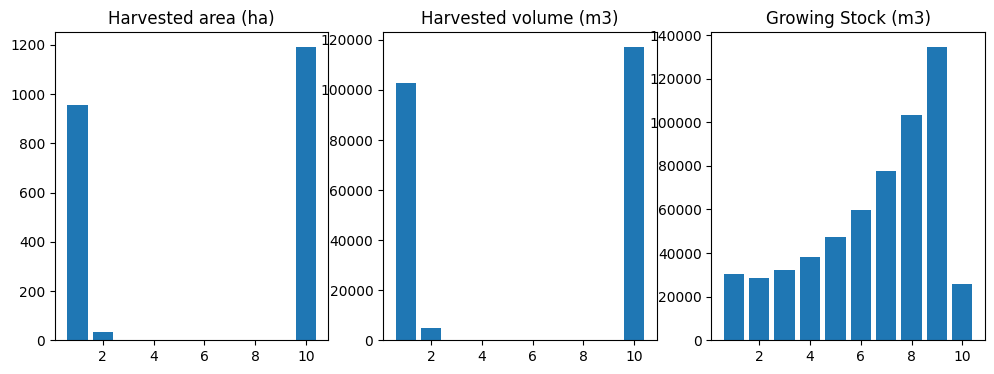

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].bar(df.period, df.oha)
ax[0].set_ylim(0, None)
ax[0].set_title('Harvested area (ha)')
ax[1].bar(df.period, df.ohv)
ax[1].set_ylim(0, None)
ax[1].set_title('Harvested volume (m3)')
ax[2].bar(df.period, df.ogs)
ax[2].set_ylim(0, None)
ax[2].set_title('Growing Stock (m3)')
fig, ax

So, the optimal solution seems to be to harvest a lot of volume in the first period, then just let the forest grow for 90 years, then liquidate all operable growing stock in the final period. 

This is typical behaviour for a forest estate model when there are no even flow or growing stock constraints defined. This is a good example of why it is essential for the forest analyst formulating and solving LP optimization problems in a forest estate modelling environment to understand the four inherent assumptions of linear programming (i.e., proportionality, additivity, divisibility, and certainty). In this case, the _certainty_ assumption is relevant to understanding the behaviour of the model. The model is _certain_ that time ends after perido 10, and is therefore _certain_ that there is no reason to maintain any growing stock (hence the determination that the optimal policy is to liquidate all remaining operable growing stock before time ends).

This is why experienced analysts might set a lower bound constraint on final-period growing stock, as a proxy for future time steps (beyond the final period in the model) that that model does not (_cannot_ because of the certainty assumption) see. This is a common practice in forest estate modelling.



# Adding a Lower Bound Constraint on Final Period Growing Stock

Next we will set such a lower bound constraint on final period growing stock, and re-run the model.

Before settting this new constraint, we need to define new function that correctly calculates the optimization problem matrix coefficients for the new constraint rows.

In [16]:
def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator.

    This function takes a ForestModel instance and other parameters to evaluate 
    an expression along a specified leaf-to-root-node path. It returns a dictionary 
    where keys are timestamps (t) and values are the results of evaluating the given 
    expression at each timestamp, with optional filtering based on the provided mask.

    Parameters:
        fm (ForestModel): The ForestModel instance to use for evaluation.
        path: A list of nodes representing one path in one tree in the optimization problem. 
        yname (str): The name of the yield component used for output coefficient lookup. 
        mask (tuple or string, optional): An optional dictionary that specifies which data types 
                               should be used for filtering.

    Returns:
        dict: A dictionary where keys are timestamps and values are the constraint coefficients for the matrix.
    """
    result = {}
    # Iterate over each node in the specified path
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue # filter by mask
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
    return result


Now we can use the `functools.partial` function to create a new version of the `cmp_c_i` function that takes two arguments (i.e., a `ForestModel` instance and a `Path` object), and map this to constraint name `cgen_gs` in the `coeff_funcs` dictionary (which already contains a mapping to the objective function coefficient function, from a previous step).

In [17]:
coeff_funcs['cgen_gs'] = functools.partial(cmp_c_ci, yname=tvy_name, mask=None)

Next we need to create the `cgen_data` argument for the `ForestModel.add_problem` method, which is a data structure that contains periodic lower-bound and upper-bound right-hand-side (RHS) values that we will be used to define the new end-of-horizon minimum growing stock constraint.

We can use the `ForestModel.inventory` method to query the model for initial growing stock level, so we can set the ending inventory constraint to 90% of this initial value.

In [18]:
gs_lb_rhs = fm.inventory(0, 'totvol') * 0.90 # 90% of initial growing stock level
cgen_data = {'cgen_gs':{'lb':{10:gs_lb_rhs}, 'ub':{10:999999999.}}}

The `cgen_data` argument to `ForestestModel.add_problem` is a dictionary that contains constraint names as keys and dictionaries with keys `lb` (lower bound RHS values) and `ub` (upper bound RHS values) as values.  The RHS values are also dictionaries, where each key is a period and value is the RHS value for that age.  In this case we will only define RHS values for period 10. We set the he lower bound RHS value for period 10 as 90% of initial growing stock level and the upper bound RHS value for period 10 as 999999999 (an arbitrary large number, as we want the upper bound to be a non-binding constraint).  We will use these values to define the new end-of-horizon minimum growing stock.

We can now add the new constraint using the `add_problem` method. The call to `add_problem` is almost identical to that of `add_problem` for the first scenario. The only difference is that we pass the new `cgen_data` object(containing lower-bound and upper-bound constraint RHS values) instead of passing `None` and that the `coeff_funcs` dictionary now also includes a key-value pair for the new coefficient function we defined to track periodic growing stock inventory.

In [19]:
problem = fm.add_problem(name='scenario-2', 
                         coeff_funcs=coeff_funcs, 
                         cflw_e=None, 
                         cgen_data=cgen_data, # this was set to None in the previous scenario 
                         acodes=('null', 'harvest'), 
                         sense=ws3.opt.SENSE_MAXIMIZE, 
                         mask=None)

Now we can solve our upgraded problem.

In [20]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9a81a094d8374afeb6ebaf0c5d8aea2b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9a81a094d8374afeb6ebaf0c5d8aea2b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 898 RHS
At line 933 BOUNDS
At line 1239 ENDATA
Problem MODEL has 34 rows, 305 columns and 585 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 22 (-12) rows, 153 (-152) columns and 282 (-303) elements
0  Obj 30118.102 Primal inf 401.04631 (22) Dual inf 2120212.6 (129)
31  Obj 151644.24 Primal inf 94.598784 (12)
46  Obj 130763.02
Optimal - objective value 130763.02
After Postsolve, objective 130763.02, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 130763.0182 - 46 iterations time 0.002, Presolve 0.00

We are going extend and resolve our model a few more times after this, so we can define a new `run_scenario` function that will take care of this and avoid having this notebook fill up with mostly cut-and-paste repeated blocks of code. 

In [21]:
def run_scenario(forest_model, scenario_name, sense, acodes, coeff_funcs, cflw_e, cgen_data, solver=ws3.opt.SOLVER_PULP):
    """
    Runs a forest management scenario using the provided forest model.

    Parameters:
        forest_model (object): The forest model to use for this scenario.
        scenario_name (str): A name for this scenario.
        sense (str): The optimization sense for this scenario ('minimize' or 'maximize').
        coeff_funcs (list of functions): Functions that define the coefficients for this scenario.
        cflw_e (float): The cost of flow-out for this scenario.
        cgen_data (dict): Data for generation in this scenario.
        acodes (list of str): Codes for acres to include in this scenario.
        solver (str, optional): The solver to use for this scenario. Defaults to ws3.opt.SOLVER_PULP.

    Returns:
        fig: A matplotlib figure with plots of harvested area, volume, and growing stock.
        df: A pandas DataFrame containing the compiled scenario data.
        problem: The optimization problem object used in this scenario.
    """

    # Helper function to compile scenario data
    def compile_scenario(fm):
        """
        Compiles scenario data for a given forest model.

        Parameters:
            fm (object): The forest model to use for compilation.

        Returns:
            df: A pandas DataFrame containing the compiled scenario data.
        """
        # Compile product harvest area and volume for each period in the forest model
        oha = [fm.compile_product(period, '1.', acode='harvest') for period in fm.periods]
        ohv = [fm.compile_product(period, 'totvol * 0.85', acode='harvest') for period in fm.periods]

        # Get the growing stock inventory for each period in the forest model
        ogs = [fm.inventory(period, 'totvol') for period in fm.periods]

        # Create a dictionary to hold the compiled data and convert it to a DataFrame
        data = {'period': fm.periods,
                'oha': oha,
                'ohv': ohv,
                'ogs': ogs}
        df = pd.DataFrame(data)

        return df

    # Helper function to plot scenario data
    def plot_scenario(df):
        """
        Plots the harvested area, volume, and growing stock for a given scenario.

        Parameters:
            df (pandas DataFrame): The compiled scenario data to plot.
        """
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Plot harvested area
        ax[0].bar(df.period, df.oha)
        ax[0].set_ylim(0, None)
        ax[0].set_title('Harvested Area (ha)')

        # Plot harvested volume
        ax[1].bar(df.period, df.ohv)
        ax[1].set_ylim(0, None)
        ax[1].set_title('Harvested Volume (m3)')

        # Plot growing stock
        ax[2].bar(df.period, df.ogs)
        ax[2].set_ylim(0, None)
        ax[2].set_title('Growing Stock (m3)')

        return fig, ax

    # Create the optimization problem for this scenario
    problem = forest_model.add_problem(name=scenario_name,
                                       coeff_funcs=coeff_funcs,
                                       cflw_e=cflw_e,
                                       cgen_data=cgen_data,
                                       acodes=acodes,
                                       sense=sense,
                                       mask=None)

    # Set the solver and solve the optimization problem
    problem.solver(solver)
    forest_model.reset()
    problem.solve()

    if problem.status() != ws3.opt.STATUS_OPTIMAL:
        print('Model not optimal.')
        df = None
        fig = None
    else:
        # Compile schedule from optimization problem
        schedule = forest_model.compile_schedule(problem)

        # Apply compiled schedule to the forest model
        forest_model.apply_schedule(schedule,
                                    force_integral_area=False,
                                    override_operability=False,
                                    fuzzy_age=False,
                                    recourse_enabled=False,
                                    verbose=False,
                                    compile_c_ycomps=True)

        # Re-compile scenario data with new schedule applied
        df = compile_scenario(forest_model)

        # Plot the compiled scenario data
        fig, ax = plot_scenario(df)
    return fig, df, problem


Now we can easily formulate and solve an optimization problem, compile an action schedule from the optimal solution and simulate it in `ws3`, and plot results.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0ce752bf062a4c389e4e3e9f0f7d4118-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/0ce752bf062a4c389e4e3e9f0f7d4118-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 898 RHS
At line 933 BOUNDS
At line 1239 ENDATA
Problem MODEL has 34 rows, 305 columns and 585 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 22 (-12) rows, 153 (-152) columns and 282 (-303) elements
0  Obj 30118.102 Primal inf 401.04631 (22) Dual inf 2120212.6 (129)
31  Obj 151644.24 Primal inf 94.598784 (12)
46  Obj 130763.02
Optimal - objective value 130763.02
After Postsolve, objective 130763.02, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 130763.0182 - 46 iterations time 0.002, Presolve 0.00

(<Figure size 1200x400 with 3 Axes>,
    period         oha            ohv            ogs
 0       1  956.419884  102585.020390   30405.125309
 1       2   34.885672    4798.494437   28607.304394
 2       3    0.000000       0.000000   32154.392350
 3       4    0.000000       0.000000   38166.885368
 4       5    0.000000       0.000000   47379.394949
 5       6    0.000000       0.000000   59578.656570
 6       7    0.000000       0.000000   77531.535059
 7       8    0.000000       0.000000  103522.146540
 8       9    0.000000       0.000000  134548.020901
 9      10  254.617086   23379.503383  135984.046162,
 <ws3.opt.Problem at 0x7cdfe0b83440>)

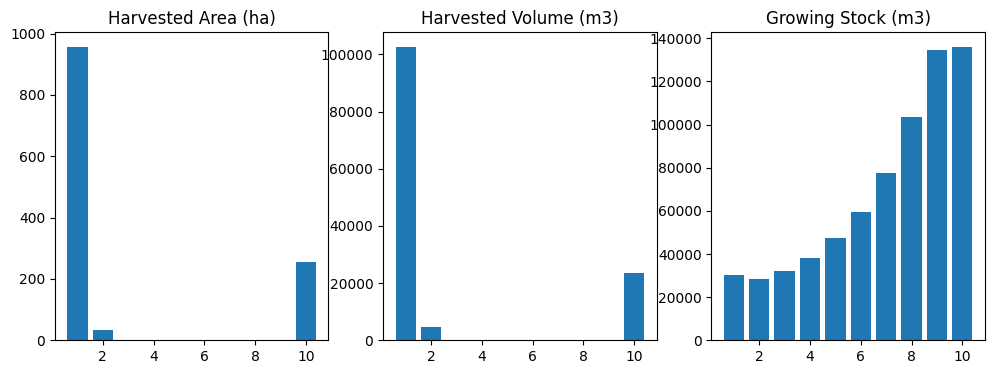

In [22]:
acodes = ['null', 'harvest']
run_scenario(fm, 'scenario-2', ws3.opt.SENSE_MAXIMIZE, acodes, coeff_funcs, None, cgen_data)

That is a bit better. At least we are not liquidating our growing stock at the ned of the simulation horizon anymore. It would be nice to reduce variation in the periodic harvest volume, however. We achieve this by adding an _even flow_ constraint to the model. 


# Adding harvest volume even-flow constraints

Even flow constraints are defined in terms of proportional variations in periodic flows, relative to a reference period.

To define an even flow constraint on harvest volume, we need a coefficient function that compiles harvest volume by period. We wil start by defining a more generic coefficient function `cmp_c_caa`, that can compile coefficients for any product depending on the value of `expr` that is passed to the function, and then later specialize this function using `functools.partial` as in previous steps.  

In [23]:
def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


In [24]:
coeff_funcs['cflw_hv'] = functools.partial(cmp_c_caa, expr='totvol * 0.85', acodes=['harvest'])

Next we need to define the `cflw_e` argument for the `add_problem` method, which defines periodic _epsilon_ values for the flow constraint (i.e., the allowable proportional variation level). See the mathematical model formulation at the top of this notebook for more details on how the epsilon parameter is used in the flow constraint definition.

Note that we need to use the same constraint name here as we used above to define the `cflw_hv` coefficient function mapping.

In [25]:
cflw_e = {'cflw_hv':({p:0.05 for p in fm.periods}, 1)}

Now we can run our model again with the new harvest volume flow constraints.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/73048e1c3a1f47e4bfb8593973469a81-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/73048e1c3a1f47e4bfb8593973469a81-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 59 COLUMNS
At line 2478 RHS
At line 2533 BOUNDS
At line 2839 ENDATA
Problem MODEL has 54 rows, 305 columns and 2145 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 43 (-11) rows, 297 (-8) columns and 1881 (-264) elements
0  Obj -0 Primal inf 424.52802 (25) Dual inf 2314494.5 (273)
31  Obj 564427 Primal inf 1711.7201 (33)
62  Obj 122777.57 Primal inf 69.532854 (16)
96  Obj 112537.98 Primal inf 10.332508 (15)
119  Obj 112180.33
Optimal - objective value 112180.33
After Postsolve, objective 112180.33, infeasibilities - dual 0 (0), pri

(<Figure size 1200x400 with 3 Axes>,
    period         oha           ohv            ogs
 0       1   81.490392  11505.674631  137557.296790
 1       2   88.328985  12080.958412  136215.193739
 2       3   75.802288  12080.958422  133278.227118
 3       4   79.588800  10930.390883  132205.401809
 4       5   79.657228  10930.390887  133028.457941
 5       6   79.744250  10930.390937  134576.453993
 6       7   80.687348  10930.390932  136326.683216
 7       8   79.987614  10930.390945  137283.043113
 8       9   79.434817  10930.390880  137053.561034
 9      10  109.767885  10930.391111  135984.045928,
 <ws3.opt.Problem at 0x7cdfce53eb70>)

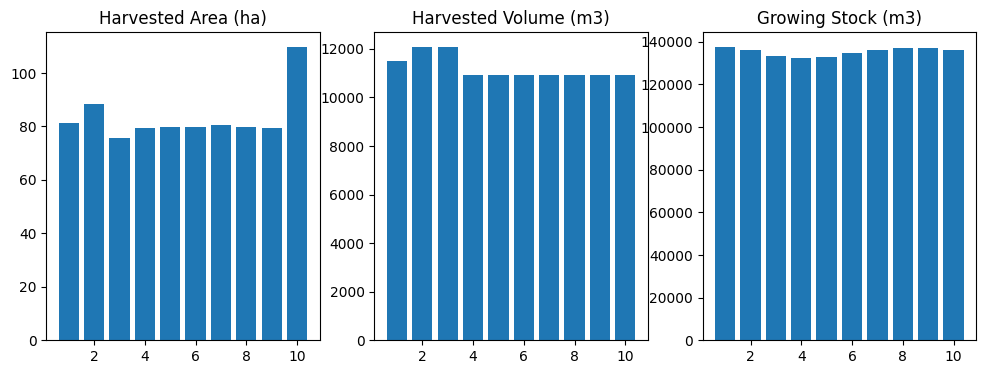

In [26]:
run_scenario(fm, 'scenario-3', ws3.opt.SENSE_MAXIMIZE, acodes, coeff_funcs, cflw_e, cgen_data)

Ta da! That is starting to look more like a sustainable harvesting solution. The combination of ending inventory constraint and even-flow harest volume constraint is effectively stabilizing both log production and growing stock inventory. There is a bit of a spike in the harvested area in the final time step, though, which we can try to mitigate by adding a flow constraint on harvest area (we will leave all the previously defined constraints in the model, including the harvest volume flow constraint we added in the previous step).


# Adding harvest area even-flow constraints

We can use the same `cmp_c_caa` coefficient function that we used above to define the harvest volume flow constraint, but just use a different value for the `expr` arg (`1.` instead of `totvol * 0.85`) in the call to `functools.partial`. We will use the same espilon value of `0.05` that we used above to define the harvest volume flow constraint.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e8114f8aa562489890dc476071af79ae-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/e8114f8aa562489890dc476071af79ae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 79 COLUMNS
At line 4058 RHS
At line 4133 BOUNDS
At line 4439 ENDATA
Problem MODEL has 74 rows, 305 columns and 3705 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 61 (-13) rows, 297 (-8) columns and 3333 (-372) elements
0  Obj -0 Primal inf 426.27061 (25) Dual inf 1935681.4 (273)
31  Obj 661471.06 Primal inf 652.95214 (35)
62  Obj 132572.66 Primal inf 199.48095 (33)
93  Obj 112433.27 Primal inf 5.1090261 (13)
119  Obj 112162.25
Optimal - objective value 112162.25
After Postsolve, objective 112162.25, infeasibilities - dual 0 (0), 

(<Figure size 1200x400 with 3 Axes>,
    period        oha           ohv            ogs
 0       1  81.826660  11503.820500  137559.478121
 1       2  85.917993  12079.011459  136294.744586
 2       3  77.735327  12079.011484  133301.038667
 3       4  79.574609  10928.629482  132230.498125
 4       5  79.642905  10928.629458  133050.020370
 5       6  79.726879  10928.629382  134579.856271
 6       7  80.671315  10928.629472  136339.199994
 7       8  79.973661  10928.629405  137337.497909
 8       9  79.420459  10928.629474  137098.794290
 9      10  77.735327  10928.629468  135984.046118,
 <ws3.opt.Problem at 0x7cdfce53f0b0>)

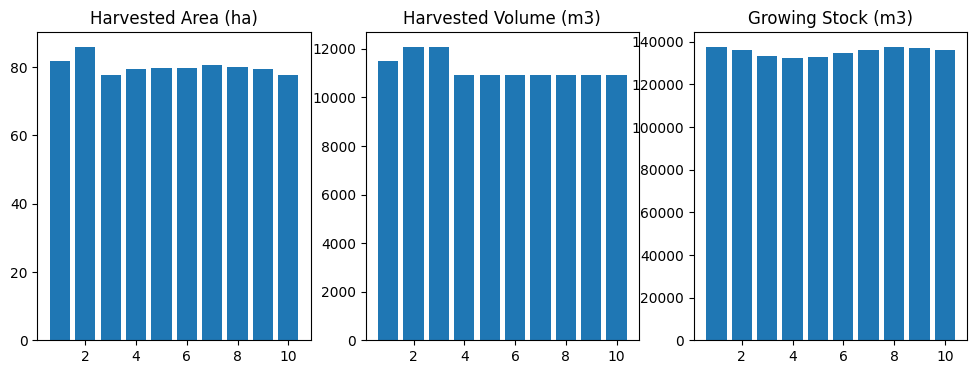

In [27]:
coeff_funcs['cflw_ha'] = functools.partial(cmp_c_caa, expr='1.', acodes=['harvest'])
cflw_e['cflw_ha'] = ({p:0.05 for p in fm.periods}, 1)

run_scenario(fm, 'scenario-4', ws3.opt.SENSE_MAXIMIZE, acodes, coeff_funcs, cflw_e, cgen_data)

Looking good! That spike in harvest area in period 10 is gone, but everything else still looks OK.


# Adding an upper bound constraint on period 1 harvest area

Now that we are on a roll and have everything all set up to update and re-run the model with a few lines of code, we can add an upper bound constraint on period 1 harvest area (maximum 40 hectares, about half the area harvested in the current solution). Even though we only constrain period 1 harvest area, the harvest area flow constraints should force a reduced harvest area in all other periods as well.  

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/40e69d3aabdd43f9872c43a5559a5383-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/40e69d3aabdd43f9872c43a5559a5383-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 81 COLUMNS
At line 4168 RHS
At line 4245 BOUNDS
At line 4551 ENDATA
Problem MODEL has 76 rows, 305 columns and 3813 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 62 (-14) rows, 297 (-8) columns and 3387 (-426) elements
0  Obj -0 Primal inf 426.27061 (25) Dual inf 1935681.4 (273)
37  Obj 90023.22 Primal inf 391.44728 (29)
78  Obj 80035.025 Primal inf 181.78862 (31)
109  Obj 71579.945 Primal inf 21.879217 (22)
142  Obj 66507.771 Primal inf 13.985737 (15)
149  Obj 66229.445
Optimal - objective value 66229.445
After Postsolve, object

(<Figure size 1200x400 with 3 Axes>,
    period   oha          ohv            ogs
 0       1  40.0  6461.409203  143491.726706
 1       2  42.0  6138.338802  149953.193058
 2       3  42.0  6138.338775  155131.331634
 3       4  42.0  6784.479650  160131.585027
 4       5  42.0  6784.479749  166636.526275
 5       6  42.0  6784.479684  172977.044750
 6       7  42.0  6784.479627  177361.949085
 7       8  42.0  6784.479686  179560.753787
 8       9  42.0  6784.479662  180216.135368
 9      10  42.0  6784.479654  180240.459472,
 <ws3.opt.Problem at 0x7cdfde186b70>)

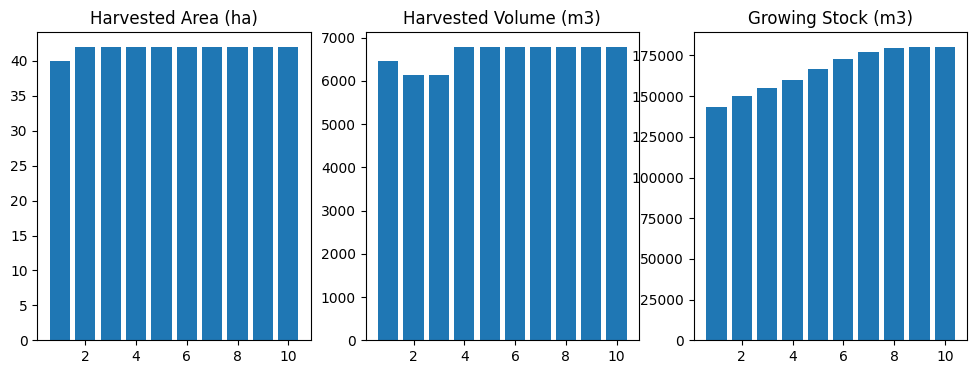

In [28]:
coeff_funcs['cgen_ha'] = functools.partial(cmp_c_caa, expr='1.', acodes=['harvest'])
cgen_data['cgen_ha'] = {'lb':{1:0.}, 'ub':{1:40.}}

run_scenario(fm, 'scenario-5', ws3.opt.SENSE_MAXIMIZE, acodes, coeff_funcs, cflw_e, cgen_data)

As expected, harvest area is down to about 40 hectares per period (and respecting even flow constraints). Not surprisingly (if you understand how forests work), this induced a similar reduction in the harvest area. Also not surprisingly, harvesting fewer trees each year results in an accumulation of growing stock in the forest (compare with the previous scenarios, where the growsing stock inventory was relatively constant throughout the simulation horizon).

# Defining an infeasible optimization model

Next, we deliberately define an infeasible pair of constraintints on the harvest area. This is done by setting the lower bound of the harvest area constraint to be 50 hectares per period and the upper bound to 40 hectares per period. 

In [29]:
cgen_data['cgen_ha'] = {'lb':{1:50.}, 'ub':{1:40.}}

run_scenario(fm, 'scenario-6', ws3.opt.SENSE_MAXIMIZE, acodes, coeff_funcs, cflw_e, cgen_data)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1046c9141d574dc4949902dc10604013-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/1046c9141d574dc4949902dc10604013-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 81 COLUMNS
At line 4168 RHS
At line 4245 BOUNDS
At line 4551 ENDATA
Problem MODEL has 76 rows, 305 columns and 3813 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj -0 Primal inf 540.52322 (34) Dual inf 1935681.4 (273)
41  Obj 90130.683 Primal inf 228.6304 (39)
84  Obj 78767.008 Primal inf 89.244474 (37)
117  Obj 71579.945 Primal inf 87.401479 (23)
134  Obj 68070.502 Primal inf 12.218581 (18)
Primal infeasible -

(None, None, <ws3.opt.Problem at 0x7cdff27bb470>)

Our `run_scenario` function does not have very advanced error handling implemented, but you can still see from the output that the problem in infeasible (so no solution compiled or displayed for this case).

You would not typically _deliberately_ define an infeasible constraint, but it is a good exercise to do so just to make sure you understand what infeasible solutions are (and how you end up with one).